In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: C:\Users\Angel\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [9]:
# Cargar el archivo CSV generado
clips_features_df = pd.read_csv('../../src/files/clips_features.csv')


In [10]:

# Mostrar las primeras filas del DataFrame para entender su estructura
print(clips_features_df.head())


          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-1        J        S1  frontal           1   
2  S1-J-frontal-1        J        S1  frontal           1   
3  S1-J-frontal-1        J        S1  frontal           1   
4  S1-J-frontal-1        J        S1  frontal           1   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   

   duration  ...      z_17      x_18      y_18      z_18      x_19      y_19  \
0  2.066667  ...  0.010676  0.533660  0.346997  0.000967  0.521835  0.319036  

In [11]:
# Inspección de tipos de datos y valores nulos
print(clips_features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38029 entries, 0 to 38028
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   clip_id          38029 non-null  object 
 1   class_id         38029 non-null  object 
 2   signer_id        38029 non-null  object 
 3   view             38029 non-null  object 
 4   repetition       38029 non-null  int64  
 5   path             38029 non-null  object 
 6   split            38029 non-null  object 
 7   fps              38029 non-null  float64
 8   n_frames         38029 non-null  int64  
 9   duration         38029 non-null  float64
 10  width            38029 non-null  int64  
 11  height           38029 non-null  int64  
 12  file_size        38029 non-null  int64  
 13  brightness_mean  38029 non-null  float64
 14  brightness_std   38029 non-null  float64
 15  blur_mean        38029 non-null  float64
 16  frame_id         38029 non-null  float64
 17  x_0         

In [12]:
# 1. **Normalización de las coordenadas** (x, y, z) de los 21 landmarks
# Este paso asegura que las coordenadas estén en el rango adecuado para cualquier modelo posterior.
scaler = StandardScaler()

In [13]:
# Selección de las columnas de coordenadas (x, y, z) para los 21 landmarks
landmark_columns = [f'x_{i}' for i in range(21)] + [f'y_{i}' for i in range(21)] + [f'z_{i}' for i in range(21)]


In [14]:
# Normalizar las coordenadas
clips_features_df[landmark_columns] = scaler.fit_transform(clips_features_df[landmark_columns])


In [15]:
print(clips_features_df.describe)

<bound method NDFrame.describe of               clip_id class_id signer_id     view  repetition  \
0      S1-J-frontal-1        J        S1  frontal           1   
1      S1-J-frontal-1        J        S1  frontal           1   
2      S1-J-frontal-1        J        S1  frontal           1   
3      S1-J-frontal-1        J        S1  frontal           1   
4      S1-J-frontal-1        J        S1  frontal           1   
...               ...      ...       ...      ...         ...   
38024  S9-Q-frontal-3        Q        S9  frontal           3   
38025  S9-Q-frontal-3        Q        S9  frontal           3   
38026  S9-Q-frontal-3        Q        S9  frontal           3   
38027  S9-Q-frontal-3        Q        S9  frontal           3   
38028  S9-Q-frontal-3        Q        S9  frontal           3   

                                                    path  split    fps  \
0      ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.00   
1      ..\..\src\datasets\MSL-dynamic

In [ ]:

# 2. **Reestructurar las coordenadas por landmark** 
# Agrupar las coordenadas (x, y, z) de cada landmark en una sola columna
new_columns = []
for i in range(21):  # Hay 21 landmarks
    new_columns.append(f'landmark_{i}')  # Nombre para la columna de cada landmark

# Crear un DataFrame con los valores de los landmarks (x, y, z)
landmark_data = []
for i in range(21):
    # Crear una lista para cada landmark, que tendrá las 3 coordenadas
    landmark_data.append(
        clips_features_df[[f'x_{i}', f'y_{i}', f'z_{i}']].values.tolist()
    )

landmark_df = pd.DataFrame({
    f'landmark_{i}': [coords for coords in clips_features_df[[f'x_{i}', f'y_{i}', f'z_{i}']].values]
    for i in range(21)
})

In [ ]:

# 3. **Concatenar los datos de landmarks con los metadatos originales**
# Mantener los metadatos del video (clip_id, etc.) y unirlo con las nuevas columnas de landmarks
final_df = pd.concat([clips_features_df.drop(columns=landmark_columns), landmark_df], axis=1)

In [ ]:

# 4. **Truncado o ajuste de los frames a 120**
def truncate_frames(df, max_frames=120):
    # Si el número de frames es menor que max_frames, repite el último frame
    if len(df) < max_frames:
        last_row = df.iloc[-1:]
        df = pd.concat([df] + [last_row]*(max_frames - len(df)), ignore_index=True)
    # Si el número de frames es mayor que max_frames, trunca el DataFrame
    elif len(df) > max_frames:
        df = df.iloc[:max_frames]
    return df

# Aplica el truncado y resetea el índice
final_df_adjusted = (
    final_df.groupby('clip_id', group_keys=False)
    .apply(truncate_frames)
    .reset_index(drop=True)
)

In [ ]:

# Verifica que cada clip_id tenga 120 registros
print(final_df_adjusted['clip_id'].value_counts())

In [ ]:
# Aplica el truncado o ajuste a los datos de cada video
# Suponiendo que 'clip_id' es el identificador del video
final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames)

In [ ]:

# 5. **Visualización de algunas de las características generadas**
# Mostrar la distribución de una de las características generadas, por ejemplo, la primera coordenada 'landmark_0_x'
plt.figure(figsize=(12, 6))
sns.histplot(final_df_adjusted['landmark_0'].apply(lambda x: x[0]), kde=True, color='blue')
plt.title('Distribución de la característica landmark_0_x')
plt.show()

In [ ]:
# 6. **Guardar el DataFrame final con las nuevas características**
final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames).reset_index(drop=True)

In [ ]:
meta_columns = [col for col in final_df_adjusted.columns if not col.startswith('landmark_')]

flattened_rows = []

for clip_id, group in final_df_adjusted.groupby('clip_id'):
    row_dict = group.iloc[0][meta_columns].to_dict()
    
    # Iterar sobre los 120 frames
    for frame_idx, (_, frame) in enumerate(group.iterrows(), 1):  # frame_idx desde 1 hasta 120
        # Iterar sobre los 21 landmarks
        for lm_idx in range(21):
            coords = frame[f'landmark_{lm_idx}']  # Esto es una lista [x,y,z]
            # Guardar cada coordenada como feature separada
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_x'] = coords[0]
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_y'] = coords[1]
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_z'] = coords[2]
    
    flattened_rows.append(row_dict)

In [ ]:
# Crear DataFrame final pivotado
pivot_df = pd.DataFrame(flattened_rows)

print(pivot_df.head())
print(f"Pivoted DataFrame shape: {pivot_df.shape}")

In [ ]:
# Guardar a CSV
pivot_df.to_csv('../../src/files/clips_features_flattened.csv', index=False)
print(f"clips_features_flattened.csv generated with {pivot_df.shape[0]} rows y {pivot_df.shape[1]} columns")


In [ ]:

flattened_rows = []

for clip_id, group in final_df_adjusted.groupby('clip_id'):
    row_dict = group.iloc[0][meta_columns].to_dict()
    # Iterar sobre los frames
    for frame_idx, (_, frame) in enumerate(group.iterrows(), 1):  # frame_idx desde 1 hasta 120
        # Iterar sobre los landmarks
        for lm_idx in range(21):
            # Guardamos la lista completa [x, y, z] sin separar
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}'] = frame[f'landmark_{lm_idx}']
    flattened_rows.append(row_dict)

# Crear DataFrame final pivotado
pivot_df = pd.DataFrame(flattened_rows)

print(pivot_df.head())
print(f"Pivoted DataFrame shape: {pivot_df.shape}")

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-1        J        S1  frontal           1   
2  S1-J-frontal-1        J        S1  frontal           1   
3  S1-J-frontal-1        J        S1  frontal           1   
4  S1-J-frontal-1        J        S1  frontal           1   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   

   duration  ...      z_17      x_18      y_18      z_18      x_19      y_19  \
0  2.066667  ...  0.010676  0.533660  0.346997  0.000967  0.521835  0.319036  

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\241162924.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(truncate_frames)


clip_id
S9-Q-frontal-3    120
S1-J-frontal-1    120
S1-J-frontal-2    120
S1-J-frontal-3    120
S8-Ñ-frontal-2    120
                 ... 
S1-K-frontal-4    120
S1-K-frontal-3    120
S1-K-frontal-2    120
S1-K-frontal-1    120
S1-J-frontal-5    120
Name: count, Length: 500, dtype: int64


C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\241162924.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames)


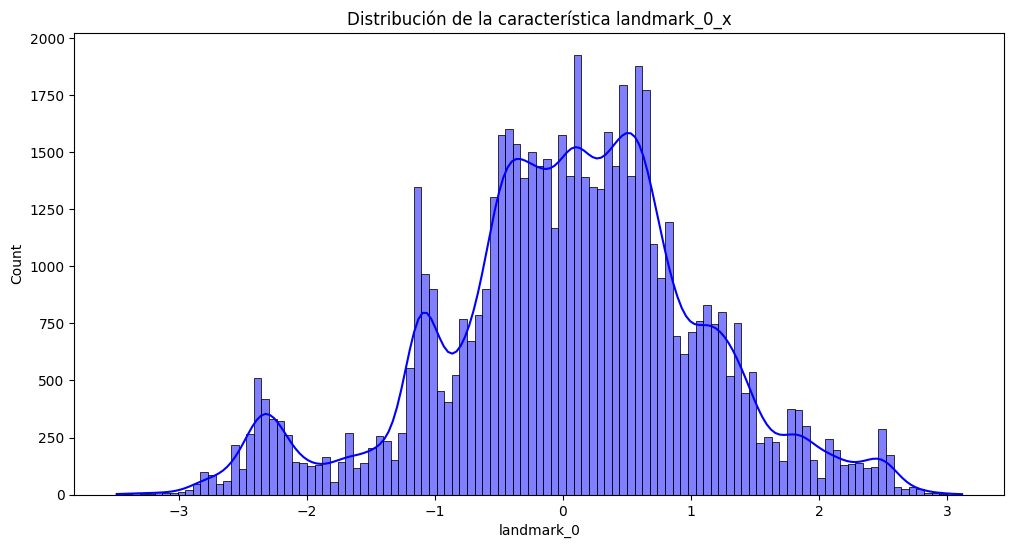

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\241162924.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames).reset_index(drop=True)


          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-2        J        S1  frontal           2   
2  S1-J-frontal-3        J        S1  frontal           3   
3  S1-J-frontal-4        J        S1  frontal           4   
4  S1-J-frontal-5        J        S1  frontal           5   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        48   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        63   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        76   

   duration  ...  landmark_17_frame_120_z  landmark_18_frame_120_x  \
0  2.066667  ...                -0.315452                 0.477219   
1  1.600000  ...  

In [ ]:
# Guardar a CSV
pivot_df.to_csv('../../src/files/clips_features_flattened_list.csv', index=False)
print(f"clips_features_flattened_list.csv generated with {pivot_df.shape[0]} rows y {pivot_df.shape[1]} columns")

In [ ]:
n_components = 250  # Número de componentes principales que quieres

In [ ]:
# --------------------------
# Procesar clips_features_flattened_list.csv
# --------------------------
df_list = pd.read_csv('../../src/files/clips_features_flattened_list.csv')
print(df_list.head())

In [ ]:
# Columnas meta
meta_columns = [col for col in df_list.columns if not col.startswith('landmark_')]
# Columnas de landmarks
landmark_columns = [col for col in df_list.columns if col.startswith('landmark_')]

In [ ]:
# Convertir listas [x,y,z] de las columnas a arrays
expanded_data = []
for col in landmark_columns:
    coords_array = df_list[col].apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else np.array(x)).to_list()
    expanded_data.append(np.vstack(coords_array))
X_list = np.hstack(expanded_data)

In [ ]:

# Aplicar PCA
pca = PCA(n_components=n_components)
X_list_pca = pca.fit_transform(X_list)

# Crear DataFrame de PCA
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
pca_df_list = pd.DataFrame(X_list_pca, columns=pca_columns)

# Concatenar metadatos
final_df_list = pd.concat([df_list[meta_columns].reset_index(drop=True), pca_df_list], axis=1)

# Guardar CSV
final_df_list.to_csv('../../src/files/clips_features_flattened_list_pca.csv', index=False)
print(f"../../src/files/clips_features_flattened_list_pca.csv generated with {final_df_list.shape[0]} rows y {final_df_list.shape[1]} columns")

In [ ]:
# --------------------------
# Procesar clips_features_flattened.csv
# --------------------------
df_flat = pd.read_csv('../../src/files/clips_features_flattened.csv')
print(df_flat.head())

In [ ]:

# Columnas meta
meta_columns_flat = [col for col in df_flat.columns if not col.startswith('landmark_')]
# Columnas de landmarks (ya separadas x,y,z)
landmark_columns_flat = [col for col in df_flat.columns if col.startswith('landmark_')]
X_flat = df_flat[landmark_columns_flat].values

In [ ]:
# Aplicar PCA
pca_flat = PCA(n_components=n_components)
X_flat_pca = pca_flat.fit_transform(X_flat)

# Crear DataFrame de PCA
pca_columns_flat = [f'PCA_{i+1}' for i in range(n_components)]
pca_df_flat = pd.DataFrame(X_flat_pca, columns=pca_columns_flat)

# Concatenar metadatos
final_df_flat = pd.concat([df_flat[meta_columns_flat].reset_index(drop=True), pca_df_flat], axis=1)

# Guardar CSV
final_df_flat.to_csv('../../src/files/clips_features_flattened_pca.csv', index=False)
print(f"clips_features_flattened_pca.csv generated with {final_df_flat.shape[0]} rows y {final_df_flat.shape[1]} columns")


C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\2518029142.py:20: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coords_array = df_list[col].apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else np.array(x)).to_list()


../../src/files/clips_features_flattened_list_pca.csv generated with 500 rows y 267 columns
clips_features_flattened_pca.csv generated with 500 rows y 267 columns
